Created by:
- Karla Sam
- Juan Cisneros

# Libraries & Mounting Drive

In [ ]:
%pip install nibabel
%pip install SimpleITK
%pip install pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52.8 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [ ]:
import nibabel as nib
import numpy as np
from scipy import stats
import pandas as pd
import os
from sklearn import cluster
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import cv2 as cv
from google.colab.patches import cv2_imshow
import SimpleITK as sitk
import pickle
from google.colab import drive

In [ ]:
# Mounting Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# Functions

### Mean function

In [ ]:
def mean_images(path):
    """
    mean_images computes the mean intensity value for each pixel in the
    registered image.

    :param path: the google path drive where the registered images are stored.
    :return: the mean intesity image of all registered images
    """
    counter = 0

    for i in os.listdir(path):
        f = os.path.join(path, i)
        image = nib.load(f).get_fdata()
        if counter == 0:
            sum_all = image
            counter += 1
        else:
            sum_all = sum_all + image
            counter += 1

    mean_all = sum_all/counter
    return mean_all

### Probability volume function

In [ ]:
def prob_vol(path, tissue):
    """
    prob_vol computes the probabilistic label volume by getting the masks for
    the given tissue for each case and computing their mean across all cases.

    :param path: the google path drive where the registered labels are stored.
    :tissue: the label value of the tissue. Possible values: 1, 2, 3
    :return: the probabilistic label volume of the given tissue
    """
    counter = 0

    for i in os.listdir(path):
        f = os.path.join(path, i)
        image = nib.load(f).get_fdata()
        if tissue == 0:
            image[image != tissue] = 1
            image = 1 - image
        else:
            image[image != tissue] = 0
            image[image == tissue] = 1

        if counter == 0:
            mask_sum = image
            counter += 1
        else:
            mask_sum = mask_sum + image
            counter += 1

    mask_prob = mask_sum/(counter)
    return mask_prob

### Tissue models function

In [ ]:
def tissue_models(path_img, path_labels):
    """
    tissue_models creates an array for each tissue with all the intensity values
    across all cases that are labeled as that tissue.

    :param path_img: the google path drive where the registered images are stored.
    :param path_labels: the google path drive where the registered labels are stored.
    :return: csf array with all intensities tagged as csf in all images
             gm array with all intensities tagged as gm in all images
             wm array with all intensities tagged as wm in all images
    """
    counter = 0

    for i, j in zip(os.listdir(path_img), os.listdir(path_labels)):
        fimg = os.path.join(path_img, i)
        flabel = os.path.join(path_labels, j)
        image = nib.load(fimg).get_fdata()
        label = nib.load(flabel).get_fdata()

        if counter == 0:
            csf = image[label == 1]
            gm = image[label == 3]
            wm = image[label == 2]
            counter += 1
        else:
            csf = np.concatenate([csf, image[label == 1]])
            gm = np.concatenate([gm, image[label == 3]])
            wm = np.concatenate([wm, image[label == 2]])
            counter += 1

    return csf, gm, wm

### Mask Function

In [ ]:
def get_mask(labeled_image, label):
    """
      This function generates the binary mask for a single tissue
      :labeled_image: image with the labels
      :label: the label of the tissue we want
    """
    mask = labeled_image.copy()
    mask[mask != label] = 0
    mask[mask == label] = 1
    return mask

### DICE Function

In [ ]:
def dice(p_labels, t_labels):
    """
    dice computes the DSC score for the segmented tissues and the ground truth.
    params:
      - p_labels -> a matrix containing the labels obtained with a segmentation algorithm.
      - t_labels -> a matrix containing the ground truth labels.
    return:
      - the DSC scores for CSF, GM and WM
    """
    csf_mask_p = get_mask(p_labels, 1)
    csf_mask_t = get_mask(t_labels, 1)

    gm_mask_p = get_mask(p_labels, 2)
    gm_mask_t = get_mask(t_labels, 3)

    wm_mask_p = get_mask(p_labels, 3)
    wm_mask_t = get_mask(t_labels, 2)

    csf_volume_sum = csf_mask_t.sum() + csf_mask_p.sum()
    csf_volume_intersect = np.sum(np.multiply(csf_mask_t, csf_mask_p))
    csf_result = 2*csf_volume_intersect / csf_volume_sum

    gm_volume_sum = gm_mask_t.sum() + gm_mask_p.sum()
    gm_volume_intersect = np.sum(np.multiply(gm_mask_t, gm_mask_p))
    gm_result = 2*gm_volume_intersect / gm_volume_sum

    wm_volume_sum = wm_mask_t.sum() + wm_mask_p.sum()
    wm_volume_intersect = np.sum(np.multiply(wm_mask_t, wm_mask_p))
    wm_result = 2*wm_volume_intersect / wm_volume_sum

    return csf_result, gm_result, wm_result

### Kmeans

In [ ]:
def my_kmeans(img):
  """
  my_kmeans generates the means and the covariance for 3 clusters (because we have three tissues).
  params:
    - img: an image matrix for which to generate the k-means
  return:
    - mean and covariance for each of the tissues, as well as the cluster_labels
  """
  img_reshaped = img.reshape(img.shape[0], 1)
  kmeans_cluster = cluster.KMeans(n_clusters=3, random_state=0)
  kmeans_cluster.fit(img_reshaped)
  cluster_labels = kmeans_cluster.labels_
  cluster_labels = cluster_labels + 1
  #labels_reshaped = np.array(cluster_labels).reshape(img.shape)
  #labels_reshaped = labels_reshaped * mask

  mu1 = np.mean(img[cluster_labels == 1])
  mu2 = np.mean(img[cluster_labels == 2])
  mu3 = np.mean(img[cluster_labels == 3])
  cov1 = np.cov(img[cluster_labels == 1], rowvar=False)
  cov2 = np.cov(img[cluster_labels == 2], rowvar=False)
  cov3 = np.cov(img[cluster_labels == 3], rowvar=False)

  return [mu1, mu2, mu3, cov1, cov2, cov3, cluster_labels]

### EM function

In [ ]:
def EM_algorithm(test_img, labeled_img, test_mask):
      """
      EM_algorithm performs the expectation-maximization algorithm to segment the tissues.
      params:
        - test_img: matrix image to segment
        - labeled_img: matrix with the ground truth segmentation
        - test_mask: matrix containing the brain mask of the image to segment.
      return:
        - labeled_img: final segmented image.
      """
      mask_flat = test_mask.reshape(-1)
      skull_stripped = test_img * test_mask

      skull_stripped_flat = skull_stripped.reshape(-1)
      labeled_image_flat = labeled_img.reshape(-1)

      # Original indexes for reconstruction and flattened masked volume
      idx = np.where(mask_flat != 0)
      idx = idx[0] # idx has two elements (array[...], ), hence idx[0]
      skull_stripped_mask = skull_stripped_flat[mask_flat != 0] ######
      labeled_image_mask = labeled_image_flat[mask_flat != 0]

      # INITIAL PARAMETERS
      #alphas
      csf_count = np.count_nonzero(labeled_img == 1)
      gm_count = np.count_nonzero(labeled_img == 2)
      wm_count = np.count_nonzero(labeled_img == 3)
      bg_count = np.count_nonzero(labeled_img == 0)
      total_count = csf_count + gm_count + wm_count + bg_count

      a1 = csf_count/total_count
      a2 = gm_count/total_count
      a3 = wm_count/total_count

      #means
      mu_CSF = np.mean(skull_stripped_mask[labeled_image_mask == 1])
      mu_GM = np.mean(skull_stripped_mask[labeled_image_mask == 2])
      mu_WM = np.mean(skull_stripped_mask[labeled_image_mask == 3])
      #covariances
      cov_CSF = np.cov(skull_stripped_mask[labeled_image_mask == 1])
      cov_GM = np.cov(skull_stripped_mask[labeled_image_mask == 2])
      cov_WM =  np.cov(skull_stripped_mask[labeled_image_mask == 3])

      # For Stopping criteria
      log_diff = 1000
      log_past = 0

      # EM LOOP
      while log_diff > 0.02:
          # Gaussian mixture model
          p1 = stats.multivariate_normal.pdf(skull_stripped_mask, mean=mu_CSF, cov=cov_CSF)
          p2 = stats.multivariate_normal.pdf(skull_stripped_mask, mean=mu_GM, cov=cov_GM)
          p3 = stats.multivariate_normal.pdf(skull_stripped_mask, mean=mu_WM, cov=cov_WM)

          # Membership weights
          w1 = (p1*a1)/(p1*a1+p2*a2+p3*a3)
          w2 = (p2*a2)/(p1*a1+p2*a2+p3*a3)
          w3 = (p3*a3)/(p1*a1+p2*a2+p3*a3)

          # New alfas
          N1 = np.sum(w1)
          N2 = np.sum(w2)
          N3 = np.sum(w3)
          a1 = N1/len(w1)
          a2 = N2/len(w2)
          a3 = N3/len(w3)

          # New means
          mu_CSF = (1/N1) * np.dot(w1, skull_stripped_mask)
          mu_GM = (1/N2) * np.dot(w2, skull_stripped_mask)
          mu_WM = (1/N3) * np.dot(w3, skull_stripped_mask)

          # New covariances
          subs1 =  np.subtract(skull_stripped_mask, mu_CSF)
          subs1_transpose = subs1.transpose()
          subs2 =  np.subtract(skull_stripped_mask, mu_GM)
          subs2_transpose = subs2.transpose()
          subs3 =  np.subtract(skull_stripped_mask, mu_WM)
          subs3_transpose = subs3.transpose()

          cov_CSF = (1/N1) * np.dot(w1, subs1*subs1_transpose)
          cov_GM = (1/N2) * np.dot(w2, subs2*subs2_transpose)
          cov_WM = (1/N3) * np.dot(w3, subs3*subs3_transpose)

          # Log likelihood
          log_current = np.sum(np.log((a1*p1)+(a2*p2)+(a3*p3)))
          log_diff = abs(log_current - log_past)
          log_past = log_current
          # print('Log likelihood diff: ' + str(log_diff))

      # Final weights and labels
      weights = np.vstack((w1, w2, w3))
      final_labels = np.argmax(weights, axis=0)
      final_labels = final_labels + 1

      # Labels reshaped
      f_reconstruction = np.zeros_like(skull_stripped_flat)
      f_reconstruction[idx] = final_labels
      labeled_image = np.array(f_reconstruction).reshape(skull_stripped.shape)
      return labeled_image

In [ ]:
def EM_algorithm(test_img, labeled_img, test_mask, flag='others'):
      mask_flat = test_mask.reshape(-1)
      skull_stripped = test_img * test_mask

      skull_stripped_flat = skull_stripped.reshape(-1)
      labeled_image_flat = labeled_img.reshape(-1)

      # Original indexes for reconstruction and flattened masked volume
      idx = np.where(mask_flat != 0)
      idx = idx[0] # idx has two elements (array[...], ) and we just want the array, hence idx[0]
      skull_stripped_mask = skull_stripped_flat[mask_flat != 0] ######
      labeled_image_mask = labeled_image_flat[mask_flat != 0]

      # INITIAL PARAMETERS
      #alphas
      csf_count = np.count_nonzero(labeled_img == 1)
      gm_count = np.count_nonzero(labeled_img == 2)
      wm_count = np.count_nonzero(labeled_img == 3)
      bg_count = np.count_nonzero(labeled_img == 0)
      total_count = csf_count + gm_count + wm_count + bg_count

      a1 = csf_count/total_count
      a2 = gm_count/total_count
      a3 = wm_count/total_count

      if flag == 'others':
            #means
            mu_CSF = np.mean(skull_stripped_mask[labeled_image_mask == 1])
            mu_GM = np.mean(skull_stripped_mask[labeled_image_mask == 2])
            mu_WM = np.mean(skull_stripped_mask[labeled_image_mask == 3])
            #covariances
            cov_CSF = np.cov(skull_stripped_mask[labeled_image_mask == 1])
            cov_GM = np.cov(skull_stripped_mask[labeled_image_mask == 2])
            cov_WM =  np.cov(skull_stripped_mask[labeled_image_mask == 3])
      else:
            #means
            mu1 = my_kmeans(skull_stripped_mask)[0]
            mu2 = my_kmeans(skull_stripped_mask)[1]
            mu3 = my_kmeans(skull_stripped_mask)[2]
            #covariances
            cov1 = my_kmeans(skull_stripped_mask)[3]
            cov2 = my_kmeans(skull_stripped_mask)[4]
            cov3 = my_kmeans(skull_stripped_mask)[5]
            #k-means
            kmeans_labels = my_kmeans(skull_stripped_mask)[6]

            ########### SORT MEANS AND COVS
            #Sorted to have the means and covariances in the same place, and then assign both of them to each tissue
            means_arr = np.array([mu1,mu2,mu3])
            sorted_means = np.sort(means_arr)
            idx_mu1 = np.where(means_arr == mu1)
            idx_mu2 = np.where(means_arr == mu2)
            idx_mu3 = np.where(means_arr == mu3)

            sorted_cov = np.zeros(3)
            sorted_cov[idx_mu1] = cov1
            sorted_cov[idx_mu2] = cov2
            sorted_cov[idx_mu3] = cov3

            mu_CSF = sorted_means[2]
            mu_GM = sorted_means[0]
            mu_WM = sorted_means[1]

            cov_CSF = sorted_cov[2]
            cov_GM = sorted_cov[0]
            cov_WM = sorted_cov[1]

      # For Stopping criteria
      log_diff = 1000
      log_past = 0
      # EM LOOP
      while log_diff > 0.02:
          # Gaussian mixture model
          p1 = stats.multivariate_normal.pdf(skull_stripped_mask, mean=mu_CSF, cov=cov_CSF)
          p2 = stats.multivariate_normal.pdf(skull_stripped_mask, mean=mu_GM, cov=cov_GM)
          p3 = stats.multivariate_normal.pdf(skull_stripped_mask, mean=mu_WM, cov=cov_WM)

          # Membership weights
          w1 = (p1*a1)/(p1*a1+p2*a2+p3*a3)
          w2 = (p2*a2)/(p1*a1+p2*a2+p3*a3)
          w3 = (p3*a3)/(p1*a1+p2*a2+p3*a3)

          # New alfas
          N1 = np.sum(w1)
          N2 = np.sum(w2)
          N3 = np.sum(w3)
          a1 = N1/len(w1)
          a2 = N2/len(w2)
          a3 = N3/len(w3)

          # New means
          mu_CSF = (1/N1) * np.dot(w1, skull_stripped_mask)
          mu_GM = (1/N2) * np.dot(w2, skull_stripped_mask)
          mu_WM = (1/N3) * np.dot(w3, skull_stripped_mask)

          # New covariances
          subs1 =  np.subtract(skull_stripped_mask, mu_CSF)
          subs1_transpose = subs1.transpose()
          subs2 =  np.subtract(skull_stripped_mask, mu_GM)
          subs2_transpose = subs2.transpose()
          subs3 =  np.subtract(skull_stripped_mask, mu_WM)
          subs3_transpose = subs3.transpose()

          cov_CSF = (1/N1) * np.dot(w1, subs1*subs1_transpose)
          cov_GM = (1/N2) * np.dot(w2, subs2*subs2_transpose)
          cov_WM = (1/N3) * np.dot(w3, subs3*subs3_transpose)

          # Log likelihood
          log_current = np.sum(np.log((a1*p1)+(a2*p2)+(a3*p3)))
          log_diff = abs(log_current - log_past)
          log_past = log_current
          # print('Log likelihood diff: ' + str(log_diff))

      # Final weights and labels
      if flag != 'kmeans':
          weights = np.vstack((w1, w2, w3))
      else:
          weights = np.vstack((w3, w1, w2)) ### jUST FOR KMEANS
      final_labels = np.argmax(weights, axis=0)
      final_labels = final_labels + 1

      # Labels reshaped
      f_reconstruction = np.zeros_like(skull_stripped_flat)
      f_reconstruction[idx] = final_labels
      labeled_image = np.array(f_reconstruction).reshape(skull_stripped.shape)
      return labeled_image

### EM function k-means

In [ ]:
def EM_algorithm_kmeans(test_img, test_mask, flag='kmeans'):
      mask_flat = test_mask.reshape(-1)
      skull_stripped = test_img * test_mask

      skull_stripped_flat = skull_stripped.reshape(-1)

      # Original indexes for reconstruction and flattened masked volume
      idx = np.where(mask_flat != 0)
      idx = idx[0] # idx has two elements (array[...], ) and we just want the array, hence idx[0]
      skull_stripped_mask = skull_stripped_flat[mask_flat != 0] ######

      # INITIAL PARAMETERS
      #alphas
      a1 = 1/3
      a2 = 1/3
      a3 = 1/3

      #means
      mu1 = my_kmeans(skull_stripped_mask)[0]
      mu2 = my_kmeans(skull_stripped_mask)[1]
      mu3 = my_kmeans(skull_stripped_mask)[2]
      #covariances
      cov1 = my_kmeans(skull_stripped_mask)[3]
      cov2 = my_kmeans(skull_stripped_mask)[4]
      cov3 = my_kmeans(skull_stripped_mask)[5]
      #k-means
      kmeans_labels = my_kmeans(skull_stripped_mask)[6]

      ########### SORT MEANS AND COVS
      #Sorted to have the means and covariances in the same place, and then assign both of them to each tissue
      means_arr = np.array([mu1,mu2,mu3])
      sorted_means = np.sort(means_arr)
      idx_mu1 = np.where(means_arr == mu1)
      idx_mu2 = np.where(means_arr == mu2)
      idx_mu3 = np.where(means_arr == mu3)

      sorted_cov = np.zeros(3)
      sorted_cov[idx_mu1] = cov1
      sorted_cov[idx_mu2] = cov2
      sorted_cov[idx_mu3] = cov3

      mu_CSF = sorted_means[0]
      mu_GM = sorted_means[1]
      mu_WM = sorted_means[2]

      cov_CSF = sorted_cov[0]
      cov_GM = sorted_cov[1]
      cov_WM = sorted_cov[2]

      # For Stopping criteria
      log_diff = 1000
      log_past = 0
      # EM LOOP
      while log_diff > 0.02:
          # Gaussian mixture model
          p1 = stats.multivariate_normal.pdf(skull_stripped_mask, mean=mu_CSF, cov=cov_CSF)
          p2 = stats.multivariate_normal.pdf(skull_stripped_mask, mean=mu_GM, cov=cov_GM)
          p3 = stats.multivariate_normal.pdf(skull_stripped_mask, mean=mu_WM, cov=cov_WM)

          # Membership weights
          w1 = (p1*a1)/(p1*a1+p2*a2+p3*a3)
          w2 = (p2*a2)/(p1*a1+p2*a2+p3*a3)
          w3 = (p3*a3)/(p1*a1+p2*a2+p3*a3)

          # New alfas
          N1 = np.sum(w1)
          N2 = np.sum(w2)
          N3 = np.sum(w3)
          a1 = N1/len(w1)
          a2 = N2/len(w2)
          a3 = N3/len(w3)

          # New means
          mu_CSF = (1/N1) * np.dot(w1, skull_stripped_mask)
          mu_GM = (1/N2) * np.dot(w2, skull_stripped_mask)
          mu_WM = (1/N3) * np.dot(w3, skull_stripped_mask)

          # New covariances
          subs1 =  np.subtract(skull_stripped_mask, mu_CSF)
          subs1_transpose = subs1.transpose()
          subs2 =  np.subtract(skull_stripped_mask, mu_GM)
          subs2_transpose = subs2.transpose()
          subs3 =  np.subtract(skull_stripped_mask, mu_WM)
          subs3_transpose = subs3.transpose()

          cov_CSF = (1/N1) * np.dot(w1, subs1*subs1_transpose)
          cov_GM = (1/N2) * np.dot(w2, subs2*subs2_transpose)
          cov_WM = (1/N3) * np.dot(w3, subs3*subs3_transpose)

          # Log likelihood
          log_current = np.sum(np.log((a1*p1)+(a2*p2)+(a3*p3)))
          log_diff = abs(log_current - log_past)
          log_past = log_current
          # print('Log likelihood diff: ' + str(log_diff))

      # Final weights and labels
      weights = np.vstack((w1, w2, w3))
      final_labels = np.argmax(weights, axis=0)
      final_labels = final_labels + 1

      # Labels reshaped
      f_reconstruction = np.zeros_like(skull_stripped_flat)
      f_reconstruction[idx] = final_labels
      labeled_image = np.array(f_reconstruction).reshape(skull_stripped.shape)
      return labeled_image

### EM function add atlas

In [ ]:
def EM_algorithm_add_atlas(test_img, labeled_img, test_mask, atlas_csf, atlas_gm, atlas_wm, flag='others'):
      mask_flat = test_mask.reshape(-1)
      skull_stripped = test_img * test_mask

      skull_stripped_flat = skull_stripped.reshape(-1)
      labeled_image_flat = labeled_img.reshape(-1)

      atlas_csf_flat = atlas_csf.reshape(-1)
      atlas_gm_flat = atlas_gm.reshape(-1)
      atlas_wm_flat = atlas_wm.reshape(-1)


      # Original indexes for reconstruction and flattened masked volume
      idx = np.where(mask_flat != 0)
      idx = idx[0] # idx has two elements (array[...], ) and we just want the array, hence idx[0]
      skull_stripped_mask = skull_stripped_flat[mask_flat != 0] ######
      labeled_image_mask = labeled_image_flat[mask_flat != 0]

      atlas_csf_mask = atlas_csf_flat[mask_flat != 0]
      atlas_gm_mask = atlas_gm_flat[mask_flat != 0]
      atlas_wm_mask = atlas_wm_flat[mask_flat != 0]

      # INITIAL PARAMETERS
      #alphas
      csf_count = np.count_nonzero(labeled_img == 1)
      gm_count = np.count_nonzero(labeled_img == 2)
      wm_count = np.count_nonzero(labeled_img == 3)
      bg_count = np.count_nonzero(labeled_img == 0)
      total_count = csf_count + gm_count + wm_count + bg_count

      a1 = csf_count/total_count
      a2 = gm_count/total_count
      a3 = wm_count/total_count

      if flag != 'kmeans':
            #means
            mu_CSF = np.mean(skull_stripped_mask[labeled_image_mask == 1])
            mu_GM = np.mean(skull_stripped_mask[labeled_image_mask == 2])
            mu_WM = np.mean(skull_stripped_mask[labeled_image_mask == 3])
            #covariances
            cov_CSF = np.cov(skull_stripped_mask[labeled_image_mask == 1])
            cov_GM = np.cov(skull_stripped_mask[labeled_image_mask == 2])
            cov_WM =  np.cov(skull_stripped_mask[labeled_image_mask == 3])
      else:
            #means
            mu1 = my_kmeans(skull_stripped_mask)[0]
            mu2 = my_kmeans(skull_stripped_mask)[1]
            mu3 = my_kmeans(skull_stripped_mask)[2]
            #covariances
            cov1 = my_kmeans(skull_stripped_mask)[3]
            cov2 = my_kmeans(skull_stripped_mask)[4]
            cov3 = my_kmeans(skull_stripped_mask)[5]
            #k-means
            kmeans_labels = my_kmeans(skull_stripped_mask)[6]

            ########### SORT MEANS AND COVS
            #Sorted to have the means and covariances in the same place, and then assign both of them to each tissue
            means_arr = np.array([mu1,mu2,mu3])
            sorted_means = np.sort(means_arr)
            idx_mu1 = np.where(means_arr == mu1)
            idx_mu2 = np.where(means_arr == mu2)
            idx_mu3 = np.where(means_arr == mu3)

            sorted_cov = np.zeros(3)
            sorted_cov[idx_mu1] = cov1
            sorted_cov[idx_mu2] = cov2
            sorted_cov[idx_mu3] = cov3

            mu_CSF = sorted_means[2]
            mu_GM = sorted_means[0]
            mu_WM = sorted_means[1]

            cov_CSF = sorted_cov[2]
            cov_GM = sorted_cov[0]
            cov_WM = sorted_cov[1]

      # For Stopping criteria
      log_diff = 1000
      log_past = 0
      # EM LOOP
      while log_diff > 0.02:
          # Gaussian mixture model
          p1 = stats.multivariate_normal.pdf(skull_stripped_mask, mean=mu_CSF, cov=cov_CSF)
          p2 = stats.multivariate_normal.pdf(skull_stripped_mask, mean=mu_GM, cov=cov_GM)
          p3 = stats.multivariate_normal.pdf(skull_stripped_mask, mean=mu_WM, cov=cov_WM)

          # Membership weights
          w1 = (p1*a1)/(p1*a1+p2*a2+p3*a3) * atlas_csf_mask
          w2 = (p2*a2)/(p1*a1+p2*a2+p3*a3) * atlas_gm_mask
          w3 = (p3*a3)/(p1*a1+p2*a2+p3*a3) * atlas_wm_mask

          # New alfas
          N1 = np.sum(w1)
          N2 = np.sum(w2)
          N3 = np.sum(w3)
          a1 = N1/len(w1)
          a2 = N2/len(w2)
          a3 = N3/len(w3)

          # New means
          mu_CSF = (1/N1) * np.dot(w1, skull_stripped_mask)
          mu_GM = (1/N2) * np.dot(w2, skull_stripped_mask)
          mu_WM = (1/N3) * np.dot(w3, skull_stripped_mask)

          # New covariances
          subs1 =  np.subtract(skull_stripped_mask, mu_CSF)
          subs1_transpose = subs1.transpose()
          subs2 =  np.subtract(skull_stripped_mask, mu_GM)
          subs2_transpose = subs2.transpose()
          subs3 =  np.subtract(skull_stripped_mask, mu_WM)
          subs3_transpose = subs3.transpose()

          cov_CSF = (1/N1) * np.dot(w1, subs1*subs1_transpose)
          cov_GM = (1/N2) * np.dot(w2, subs2*subs2_transpose)
          cov_WM = (1/N3) * np.dot(w3, subs3*subs3_transpose)

          # Log likelihood
          log_current = np.sum(np.log((a1*p1)+(a2*p2)+(a3*p3)))
          log_diff = abs(log_current - log_past)
          log_past = log_current
          # print('Log likelihood diff: ' + str(log_diff))

      # Final weights and labels
      if flag != 'kmeans':
          weights = np.vstack((w1, w2, w3))
      else:
          weights = np.vstack((w3, w1, w2)) ### jUST FOR KMEANS
      final_labels = np.argmax(weights, axis=0)
      final_labels = final_labels + 1

      # Labels reshaped
      f_reconstruction = np.zeros_like(skull_stripped_flat)
      f_reconstruction[idx] = final_labels
      labeled_image = np.array(f_reconstruction).reshape(skull_stripped.shape)
      return labeled_image

# Create tissue models and Probability Maps from Training Set

###Paths

In [ ]:
# Getting the paths
path_img = '/content/drive/MyDrive/Brain Atlas/RegImgs/'
path_labels = '/content/drive/MyDrive/Brain Atlas/RegLabels/'

###Mean of registered images and probability label volumes for each tissue

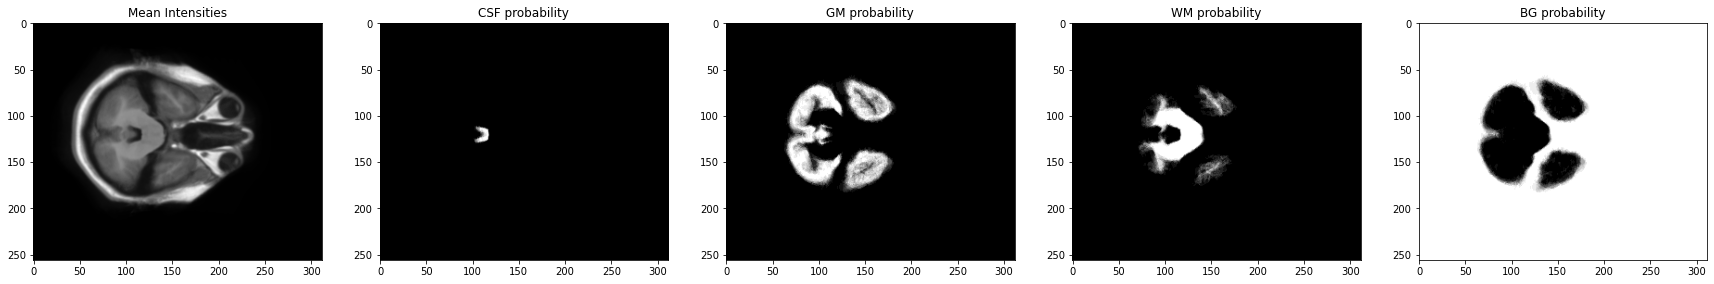

In [ ]:
# Compute mean of intensities
avgImg = mean_images(path_img)

# Get probability label volumes
prob_csf = prob_vol(path_labels, 1)
prob_gm = prob_vol(path_labels, 3)
prob_wm = prob_vol(path_labels, 2)
prob_bg = prob_vol(path_labels, 0)

# Show mean image and probability label volumes
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(30,24))
ax1.imshow(avgImg[:,:,100], cmap='gray')
ax2.imshow(prob_csf[:,:,100], cmap='gray')
ax3.imshow(prob_gm[:,:,100], cmap='gray')
ax4.imshow(prob_wm[:,:,100], cmap='gray')
ax5.imshow(prob_bg[:,:,100], cmap='gray')

ax1.title.set_text('Mean Intensities')
ax2.title.set_text('CSF probability')
ax3.title.set_text('GM probability')
ax4.title.set_text('WM probability')
ax5.title.set_text('BG probability')
plt.show(block=True)

### Tissue models

In [ ]:
model = tissue_models(path_img, path_labels)
csf_model = model[0]
gm_model = model[1]
wm_model = model[2]

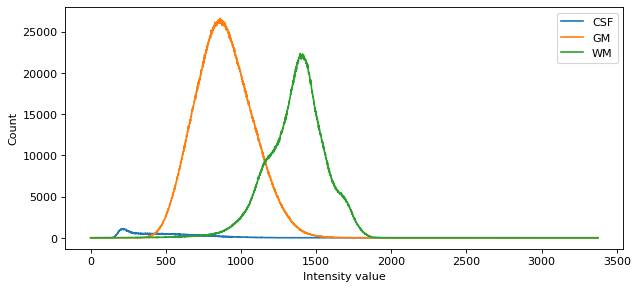

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


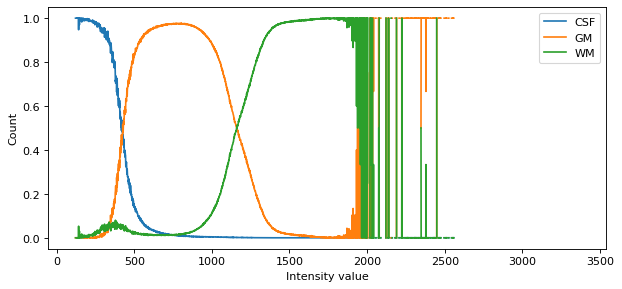

In [ ]:
# Get the maximum intensity value across all tissues
all_tissues = np.concatenate([csf_model, gm_model, wm_model])
max_val = int(np.amax(all_tissues))

# Array with x-axis values
x_vals = np.arange(max_val)

# Show plots without normalization
hist_csf, edges_csf = np.histogram(np.uint16(csf_model), range=(0, max_val),bins=max_val)
hist_gm, edges_gm = np.histogram(np.uint16(gm_model), range=(0, max_val),bins=max_val)
hist_wm, edges_wm = np.histogram(np.uint16(wm_model), range=(0, max_val),bins=max_val)

figure(figsize=(9, 4), dpi=80)
plt.plot(x_vals, hist_csf, label="CSF")
plt.plot(x_vals, hist_gm, label="GM")
plt.plot(x_vals, hist_wm, label="WM")
plt.legend(loc="upper right")
plt.xlabel('Intensity value')
plt.ylabel('Count')
plt.show()

## Show plots normalized
total = hist_csf + hist_gm + hist_wm
csf_total = hist_csf/total
gm_total = hist_gm/total
wm_total = hist_wm/total

figure(figsize=(9, 4), dpi=80)
plt.plot(x_vals, csf_total, label="CSF")
plt.plot(x_vals, gm_total, label="GM")
plt.plot(x_vals, wm_total, label="WM")
plt.xlabel('Intensity value')
plt.ylabel('Count')
plt.legend(loc="upper right")

plt.show()

###Saving NIFT files

In [ ]:
# # Fixed image data for saving the files
# f_img_data = nib.load('/content/drive/MyDrive/Brain Atlas/RegImgs/resultImg1006.nii')
# f_img = f_img_data.get_fdata()

# # Saving Mean Intensity Image
# avgImg2 = nib.Nifti1Image(avgImg, f_img_data.affine, f_img_data.header)
# nib.save(avgImg2, 'avgImg.nii.gz')

# # Saving Label Probability Volumes
# prob_csf2 = nib.Nifti1Image(prob_csf, f_img_data.affine, f_img_data.header)
# nib.save(prob_csf2, 'prob_csf.nii.gz')

# prob_wm2 = nib.Nifti1Image(prob_wm, f_img_data.affine, f_img_data.header)
# nib.save(prob_wm2, 'prob_wm.nii.gz')

# prob_gm2 = nib.Nifti1Image(prob_gm, f_img_data.affine, f_img_data.header)
# nib.save(prob_gm2, 'prob_gm.nii.gz')

# Segmentation Initialization

### Paths

In [ ]:
# Getting the paths
path_our_atlas = '/content/drive/MyDrive/Transformed_Images/'
path_mni_atlas = '/content/drive/MyDrive/MNI_trans_imgs/'
path_test_images = '/content/drive/MyDrive/Test_set/testing_images/'
path_test_labels = '/content/drive/MyDrive/Test_set/testing_labels/'
path_test_masks = '/content/drive/MyDrive/Test_set/testing_mask/'

### Get labels from tissue models

In [ ]:
## Clean NaNs
csf_total_model = np.nan_to_num(csf_total.copy())
gm_total_model = np.nan_to_num(gm_total.copy())
wm_total_model = np.nan_to_num(wm_total.copy())

## Make intensities higher than 1500 into WM
csf_total_model[1500:] = 0
gm_total_model[1500:] = 0
wm_total_model[1500:] = 1

## Make array bigger in case of higher intensities and assign them to WM
end_array_csf = np.full(4000, 0)
end_array_gm = np.full(4000, 0)
end_array_wm = np.full(4000, 1)
csf_total_model = np.concatenate((csf_total_model, end_array_csf), axis=None)
gm_total_model = np.concatenate((gm_total_model, end_array_gm), axis=None)
wm_total_model = np.concatenate((wm_total_model, end_array_wm), axis=None)

## Stack all tissue models
tissue_models_total = np.vstack((csf_total_model, gm_total_model, wm_total_model))

## Get the argmax for the probabilities
intensity_labels = np.argmax(tissue_models_total, axis=0) + 1

### Creating and sorting arrays with file names

In [ ]:
## Initialize arrays for file names
fouratlas_array = np.empty(0)
fourcsf_array = np.empty(0)
fourgm_array = np.empty(0)
fourwm_array = np.empty(0)

fmniatlas_array = np.empty(0)
fmnicsf_array = np.empty(0)
fmnigm_array = np.empty(0)
fmniwm_array = np.empty(0)

fimg_array = np.empty(0)
fmask_array = np.empty(0)
flabels_array = np.empty(0)

## Sort the atlas files
for i in os.listdir(path_our_atlas):
      four_atlas = i
      fouratlas_array = np.append(fouratlas_array, four_atlas)
      fouratlas_array = np.sort(fouratlas_array)

for i in os.listdir(path_mni_atlas):
      fmni_atlas = i
      fmniatlas_array = np.append(fmniatlas_array, fmni_atlas)
      fmniatlas_array = np.sort(fmniatlas_array)

## Divide atlas files array into separate tissue arrays
idx = 0
while idx < 58:
      four_csf = fouratlas_array[idx]
      four_gm = fouratlas_array[idx+1]
      four_wm = fouratlas_array[idx+2]

      fmni_csf = fmniatlas_array[idx]
      fmni_gm = fmniatlas_array[idx+1]
      fmni_wm = fmniatlas_array[idx+2]

      fourcsf_array = np.append(fourcsf_array, four_csf)
      fourgm_array = np.append(fourgm_array, four_gm)
      fourwm_array = np.append(fourwm_array, four_wm)

      fmnicsf_array = np.append(fmnicsf_array, fmni_csf)
      fmnigm_array = np.append(fmnigm_array, fmni_gm)
      fmniwm_array = np.append(fmniwm_array, fmni_wm)

      idx += 3

## Sort the image, labels and mask files
for i, j, k in zip(os.listdir(path_test_images), os.listdir(path_test_masks), os.listdir(path_test_labels)):
      fimg = i
      fmask = j
      flabels = k

      fimg_array = np.append(fimg_array, fimg)
      fmask_array = np.append(fmask_array, fmask)
      flabels_array = np.append(flabels_array, flabels)

      fimg_array = np.sort(fimg_array)
      fmask_array = np.sort(fmask_array)
      flabels_array = np.sort(flabels_array)

## Create dataframe with filenames arrays
dict = {'fourcsf_array': fourcsf_array, 'fourgm_array': fourgm_array, \
        'fourwm_array': fourwm_array, 'fmnicsf_array': fmnicsf_array, \
        'fmnigm_array': fmnigm_array, 'fmniwm_array': fmniwm_array, \
        'fimg_array': fimg_array, 'fmask_array': fmask_array, 'flabels_array': flabels_array}
df_arrays = pd.DataFrame(dict)

# Segmenting with Tissue Models

### Segmenting 1 file

1257997


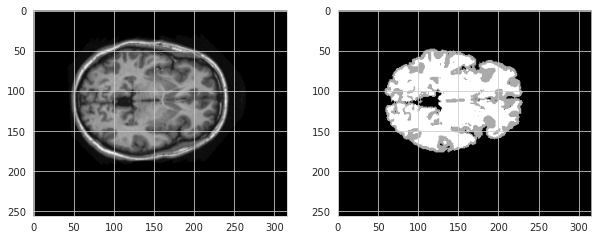

In [ ]:
## Reading data
test_image = nib.load(path_test_images + '1003.nii').get_fdata()
test_mask = nib.load(path_test_masks + '1003_1C.nii').get_fdata()

## Segmenting
test_image = test_image.astype(int)
labeled_image = intensity_labels[test_image]
labeled_image = labeled_image * test_mask

#
csf_count = np.count_nonzero(labeled_image == 1)
gm_count = np.count_nonzero(labeled_image == 2)
wm_count = np.count_nonzero(labeled_image == 3)
total_count = np.count_nonzero(labeled_image)

print(total_count)
# Show results
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,8))
ax1.imshow(test_image[:,:,143], cmap='gray')
ax2.imshow(labeled_image[:,:,143], cmap='gray')

### Segmenting all files

In [ ]:
EM_flag = 1 # 1: with EM, 0: no EM

TM_csf_scores = []
TM_gm_scores = []
TM_wm_scores = []

for idx, row in df_arrays.iterrows():

      test_image = nib.load(os.path.join(path_test_images, row["fimg_array"])).get_fdata()
      test_mask = nib.load(os.path.join(path_test_masks, row["fmask_array"])).get_fdata()
      test_labels = nib.load(os.path.join(path_test_labels, row["flabels_array"])).get_fdata()
      our_atlas_csf = nib.load(os.path.join(path_mni_atlas, row["fmnicsf_array"])).get_fdata()
      our_atlas_gm = nib.load(os.path.join(path_mni_atlas, row["fmnigm_array"])).get_fdata()
      our_atlas_wm = nib.load(os.path.join(path_mni_atlas, row["fmniwm_array"])).get_fdata()

      ## SEGMENTING
      test_image_int = test_image.astype(int).copy()
      labeled_image = intensity_labels[test_image_int]
      labeled_image = labeled_image * test_mask #

      ## Optional EM
      if EM_flag == 1:
            #labeled_image = EM_algorithm(test_image, labeled_image, test_mask)
            labeled_image = EM_algorithm_add_atlas(test_image, labeled_image, test_mask, our_atlas_csf, our_atlas_gm, our_atlas_wm)

      ## DICE SCORES
      dice_CSF = dice(labeled_image, test_labels)[0]
      dice_GM = dice(labeled_image, test_labels)[1]
      dice_WM = dice(labeled_image, test_labels)[2]

      TM_csf_scores.append(dice_CSF)
      TM_gm_scores.append(dice_GM)
      TM_wm_scores.append(dice_WM)

      print(f'Image: {row["fimg_array"][:-4]}')
      print(f'CSF DICE: {dice_CSF}')
      print(f'GM DICE: {dice_GM}')
      print(f'WM DICE: {dice_WM} \n')

Image: 1003
CSF DICE: 0.055187484017946396
GM DICE: 0.8866335066585852
WM DICE: 0.7976429023099985 

Image: 1004
CSF DICE: 0.15682368855261397
GM DICE: 0.8854116044154402
WM DICE: 0.8187484293976627 

Image: 1005
CSF DICE: 0.540794828133568
GM DICE: 0.8836088626600563
WM DICE: 0.8036325114627894 

Image: 1018
CSF DICE: 0.17220954896546203
GM DICE: 0.8894990317778811
WM DICE: 0.814068422210327 

Image: 1019
CSF DICE: 0.048398389637668474
GM DICE: 0.9010749946887614
WM DICE: 0.8240126858296114 

Image: 1023
CSF DICE: 0.06305368584183378
GM DICE: 0.8895919753227804
WM DICE: 0.813591494093627 

Image: 1024
CSF DICE: 0.13273600591169407
GM DICE: 0.899731737949362
WM DICE: 0.828768744175816 

Image: 1025
CSF DICE: 0.5260203603096614
GM DICE: 0.8853179101331319
WM DICE: 0.7990545612514919 

Image: 1038
CSF DICE: 0.1836386215461037
GM DICE: 0.8895746411095493
WM DICE: 0.819079073500804 

Image: 1039
CSF DICE: 0.05186645579218754
GM DICE: 0.8892523019091063
WM DICE: 0.8047718356841717 

Image: 

# Segmenting with Label Propagation

### Segmenting 1 file

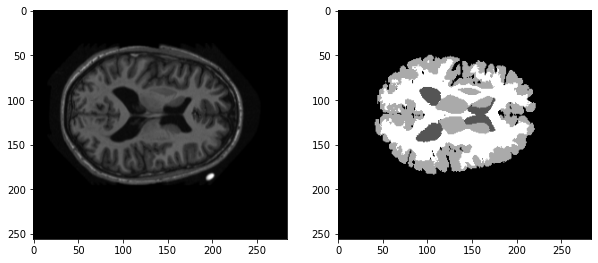

In [ ]:
## Reading data
test_image = nib.load(path_test_images + '1005.nii').get_fdata()
test_mask = nib.load(path_test_masks + '1005_1C.nii').get_fdata()

our_atlas_csf = nib.load(path_our_atlas + '1005_ours_csf.nii').get_fdata()
our_atlas_gm = nib.load(path_our_atlas + '1005_ours_gm.nii').get_fdata()
our_atlas_wm = nib.load(path_our_atlas + '1005_ours_wm.nii').get_fdata()

## Getting the argmax from the tissue volumes and masking
our_atlas_total = np.stack((our_atlas_csf, our_atlas_gm, our_atlas_wm), axis=-1)
position_labels = np.argmax(our_atlas_total, axis=-1) + 1
position_labels = position_labels * test_mask

# Show results
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,8))
ax1.imshow(test_image[:,:,143], cmap='gray')
ax2.imshow(position_labels[:,:,143], cmap='gray')

### Segmenting all files

In [ ]:
EM_flag = 1 # 1: with EM, 0: no EM

LP_csf_scores = []
LP_gm_scores = []
LP_wm_scores = []

for idx, row in df_arrays.iterrows():

      ## Reading files
      our_atlas_csf = nib.load(os.path.join(path_our_atlas, row["fourcsf_array"])).get_fdata()
      our_atlas_gm = nib.load(os.path.join(path_our_atlas, row["fourgm_array"])).get_fdata()
      our_atlas_wm = nib.load(os.path.join(path_our_atlas, row["fourwm_array"])).get_fdata()
      test_image = nib.load(os.path.join(path_test_images, row["fimg_array"])).get_fdata()
      mask = nib.load(os.path.join(path_test_masks, row["fmask_array"])).get_fdata()
      labels = nib.load(os.path.join(path_test_labels, row["flabels_array"])).get_fdata()

      # Stacking and getting the argmax
      our_atlas_total = np.stack((our_atlas_csf, our_atlas_gm, our_atlas_wm), axis=-1)
      position_labels = np.argmax(our_atlas_total, axis=-1) + 1
      position_labels = position_labels * mask ############################################# SEGMENTED IMAGE!!!!

      ## Optional EM
      if EM_flag == 1:
            position_labels = EM_algorithm(test_image, position_labels, mask)

      ## DICE SCORES
      dice_CSF = dice(position_labels, labels)[0]
      dice_GM = dice(position_labels, labels)[1]
      dice_WM = dice(position_labels, labels)[2]

      LP_csf_scores.append(dice_CSF)
      LP_gm_scores.append(dice_GM)
      LP_wm_scores.append(dice_WM)

      print(f'Image: {row["fimg_array"][:-4]}')
      print(f'CSF DICE: {dice_CSF}')
      print(f'GM DICE: {dice_GM}')
      print(f'WM DICE: {dice_WM} \n')

Image: 1003
CSF DICE: 8.344649183362286e-05
GM DICE: 0.9225224981025697
WM DICE: 0.7530231552058012 

Image: 1004
CSF DICE: 0.4064165794848802
GM DICE: 0.9338640920746359
WM DICE: 0.8965955135970592 

Image: 1005
CSF DICE: 0.7487176440298655
GM DICE: 0.9212980826060678
WM DICE: 0.8674991018943736 

Image: 1018
CSF DICE: 0.019558230185324488
GM DICE: 0.7855125919123128
WM DICE: 0.8470220390010087 

Image: 1019
CSF DICE: 0.036216363565559406
GM DICE: 0.7310420971417929
WM DICE: 0.8357012532527742 

Image: 1023
CSF DICE: 0.026541082034600507
GM DICE: 0.7391175093042105
WM DICE: 0.8412577380276401 

Image: 1024
CSF DICE: 0.3532346770992799
GM DICE: 0.9414719714851825
WM DICE: 0.9015986444953519 

Image: 1025
CSF DICE: 0.7315214782817374
GM DICE: 0.9222214797212592
WM DICE: 0.8620257122961692 

Image: 1038
CSF DICE: 0.2717308481331692
GM DICE: 0.9337872597338074
WM DICE: 0.8988751119748197 

Image: 1039
CSF DICE: 0.032756494897646884
GM DICE: 0.6264741789139763
WM DICE: 0.8028017827055818 


# Segmenting with Tissue Models & Label Propagation

### Segmenting 1 file

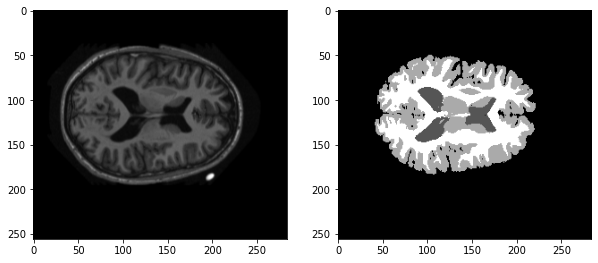

In [ ]:
## Reading data
test_image = nib.load(path_test_images + '1005.nii').get_fdata()
test_mask = nib.load(path_test_masks + '1005_1C.nii').get_fdata()

our_atlas_csf = nib.load(path_our_atlas + '1005_ours_csf.nii').get_fdata()
our_atlas_gm = nib.load(path_our_atlas + '1005_ours_gm.nii').get_fdata()
our_atlas_wm = nib.load(path_our_atlas + '1005_ours_wm.nii').get_fdata()

test_image_int = test_image.astype(int).copy()

## Segmenting
prob_csf_model = csf_total_model[test_image_int]
prob_gm_model = gm_total_model[test_image_int]
prob_wm_model = wm_total_model[test_image_int]

both_csf = np.multiply(prob_csf_model, our_atlas_csf)
both_gm = np.multiply(prob_gm_model, our_atlas_gm)
both_wm = np.multiply(prob_wm_model, our_atlas_wm)

both_total = np.stack((both_csf, both_gm, both_wm), axis=-1)
both_labels = np.argmax(both_total, axis=-1) + 1
both_labels = both_labels * test_mask

# Show results
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,8))
ax1.imshow(test_image[:,:,143], cmap='gray')
ax2.imshow(both_labels[:,:,143], cmap='gray')

### Segmenting all files

In [ ]:
EM_flag = 1 # 1: with EM, 0: no EM

BM_csf_scores = []
BM_gm_scores = []
BM_wm_scores = []

for idx, row in df_arrays.iterrows():

      ## Reading files
      our_atlas_csf = nib.load(os.path.join(path_our_atlas, row["fourcsf_array"])).get_fdata()
      our_atlas_gm = nib.load(os.path.join(path_our_atlas, row["fourgm_array"])).get_fdata()
      our_atlas_wm = nib.load(os.path.join(path_our_atlas, row["fourwm_array"])).get_fdata()
      test_image = nib.load(os.path.join(path_test_images, row["fimg_array"])).get_fdata()
      mask = nib.load(os.path.join(path_test_masks, row["fmask_array"])).get_fdata()
      labels = nib.load(os.path.join(path_test_labels, row["flabels_array"])).get_fdata()
      test_image_int = test_image.astype(int).copy()

      ## SEGMENTING
      prob_csf_model = csf_total_model[test_image_int]
      prob_gm_model = gm_total_model[test_image_int]
      prob_wm_model = wm_total_model[test_image_int]
      both_csf = np.multiply(prob_csf_model, our_atlas_csf)
      both_gm = np.multiply(prob_gm_model, our_atlas_gm)
      both_wm = np.multiply(prob_wm_model, our_atlas_wm)
      both_total = np.stack((both_csf, both_gm, both_wm), axis=-1)
      both_labels = np.argmax(both_total, axis=-1) + 1
      both_labels = both_labels * mask #

      ## Optional EM
      if EM_flag == 1:
            both_labels = EM_algorithm_add_atlas(test_image, both_labels, mask, our_atlas_csf, our_atlas_gm, our_atlas_wm)

      ## DICE SCORES
      dice_CSF = dice(both_labels, labels)[0]
      dice_GM = dice(both_labels, labels)[1]
      dice_WM = dice(both_labels, labels)[2]

      BM_csf_scores.append(dice_CSF)
      BM_gm_scores.append(dice_GM)
      BM_wm_scores.append(dice_WM)

      print(f'Image: {row["fimg_array"][:-4]}')
      print(f'CSF DICE: {dice_CSF}')
      print(f'GM DICE: {dice_GM}')
      print(f'WM DICE: {dice_WM} \n')

Image: 1003
CSF DICE: 0.40846109699106337
GM DICE: 0.9543313017443211
WM DICE: 0.9246837618476061 

Image: 1004
CSF DICE: 0.6994501423390399
GM DICE: 0.9598590339137484
WM DICE: 0.9401221618403769 

Image: 1005
CSF DICE: 0.7868280574643244
GM DICE: 0.9485213695750982
WM DICE: 0.9226466156427013 

Image: 1018
CSF DICE: 0.6609124537607891
GM DICE: 0.9562078763858787
WM DICE: 0.9310417237611535 

Image: 1019
CSF DICE: 0.43486760263017593
GM DICE: 0.9625080356018583
WM DICE: 0.935636150382645 

Image: 1023
CSF DICE: 0.47670419011882426
GM DICE: 0.9541318855275902
WM DICE: 0.9273889895280953 

Image: 1024
CSF DICE: 0.6488650360724969
GM DICE: 0.964073683858452
WM DICE: 0.942139871332812 

Image: 1025
CSF DICE: 0.7661354350225595
GM DICE: 0.9482324246724183
WM DICE: 0.9170271222261359 

Image: 1038
CSF DICE: 0.6467765302426657
GM DICE: 0.9556817309250996
WM DICE: 0.9319287375609849 

Image: 1039
CSF DICE: 0.4569020356234097
GM DICE: 0.9579966301713779
WM DICE: 0.9295571467467888 

Image: 110

# Segmentation with K-means

In [ ]:
KM_csf_scores = []
KM_gm_scores = []
KM_wm_scores = []

for idx, row in df_arrays.iterrows():

      test_image = nib.load(os.path.join(path_test_images, row["fimg_array"])).get_fdata()
      test_mask = nib.load(os.path.join(path_test_masks, row["fmask_array"])).get_fdata()
      test_labels = nib.load(os.path.join(path_test_labels, row["flabels_array"])).get_fdata()

      kmeans_labels = EM_algorithm_kmeans(test_image, test_mask, flag='kmeans')

      ## DICE SCORES
      dice_CSF = dice(kmeans_labels, test_labels)[0]
      dice_GM = dice(kmeans_labels, test_labels)[1]
      dice_WM = dice(kmeans_labels, test_labels)[2]

      KM_csf_scores.append(dice_CSF)
      KM_gm_scores.append(dice_GM)
      KM_wm_scores.append(dice_WM)

      print(f'Image: {row["fimg_array"][:-4]}')
      print(f'CSF DICE: {dice_CSF}')
      print(f'GM DICE: {dice_GM}')
      print(f'WM DICE: {dice_WM} \n')

Image: 1003
CSF DICE: 0.02625652739230415
GM DICE: 0.16624156214689817
WM DICE: 0.7530048579878685 

Image: 1004
CSF DICE: 0.03523306384908882
GM DICE: 0.0858926157485637
WM DICE: 0.7316094709732851 

Image: 1005
CSF DICE: 0.7487176440298655
GM DICE: 0.9212980826060678
WM DICE: 0.8674991018943736 

Image: 1018
CSF DICE: 0.035313587920100475
GM DICE: 0.08018469089280833
WM DICE: 0.7688020815264527 

Image: 1019
CSF DICE: 0.024803564030000863
GM DICE: 0.1826499110196232
WM DICE: 0.7732147950114803 

Image: 1023
CSF DICE: 0.024314062631002494
GM DICE: 0.1170495787526029
WM DICE: 0.7609472426097155 

Image: 1024
CSF DICE: 0.031001891171205227
GM DICE: 0.1197737309416443
WM DICE: 0.7521765523854126 

Image: 1025
CSF DICE: 0.7315214782817374
GM DICE: 0.9222214797212592
WM DICE: 0.8620257122961692 

Image: 1038
CSF DICE: 0.02451181857460508
GM DICE: 0.7727981933579517
WM DICE: 0.8522733456153853 

Image: 1039
CSF DICE: 0.026849489052795935
GM DICE: 0.1476861050640075
WM DICE: 0.71923675671255

# VISUALIZATION

### Plots

In [ ]:
Names = ['CSF', 'GM', 'WM']

In [ ]:
TM = []
TM.append(TM_csf_scores)
TM.append(TM_gm_scores)
TM.append(TM_wm_scores)

LP = []
LP.append(LP_csf_scores)
LP.append(LP_gm_scores)
LP.append(LP_wm_scores)

BM = []
BM.append(BM_csf_scores)
BM.append(BM_gm_scores)
BM.append(BM_wm_scores)

KM = []
KM.append(KM_csf_scores)
KM.append(KM_gm_scores)
KM.append(KM_wm_scores)

In [ ]:
np.savetxt("TM.csv", np.transpose(TM), delimiter= ", ", fmt = '% s')
np.savetxt("LP.csv", np.transpose(LP), delimiter= ", ", fmt = '% s')
np.savetxt("BM.csv", np.transpose(BM), delimiter= ", ", fmt = '% s')
np.savetxt("KM.csv", np.transpose(KM), delimiter= ", ", fmt = '% s')

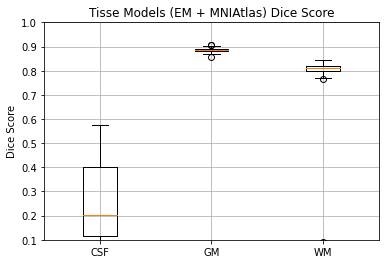

In [ ]:
import seaborn as sns

plt.boxplot(TM, labels = Names)
plt.title('Tisse Models (EM + MNIAtlas) Dice Score')
plt.ylabel('Dice Score')
sns.set_style("whitegrid")
plt.ylim(0.1,1)
plt.grid('-')
plt.show()

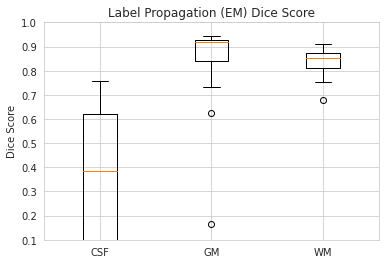

In [ ]:
plt.boxplot(LP, labels = Names)
plt.title('Label Propagation (EM) Dice Score')
plt.ylabel('Dice Score')
sns.set_style("whitegrid")
plt.ylim(0.1,1)
plt.grid('-')
plt.show()

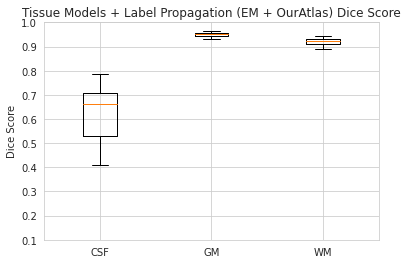

In [ ]:
plt.boxplot(BM, labels = Names)
plt.title('Tissue Models + Label Propagation (EM + OurAtlas) Dice Score')
plt.ylabel('Dice Score')
sns.set_style("whitegrid")
plt.ylim(0.1,1)
plt.grid('-')
plt.show()

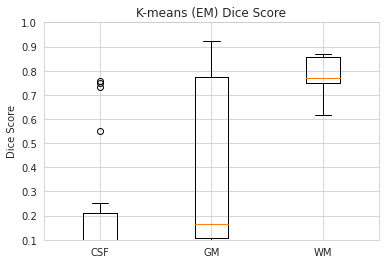

In [ ]:
plt.boxplot(KM, labels = Names)
plt.title('K-means (EM) Dice Score')
plt.ylabel('Dice Score')
sns.set_style("whitegrid")
plt.ylim(0.1,1)
plt.grid('-')
plt.show()